# Gamma Ray Reconstruction for the AdEPT Mission
### Spencer R. Deevy - deevys@mcmaster.ca

This python code is to be used as post-processing software for data collected from the future AdEPT satellite. The purpose of this code is to identify gamma ray events within the time projection chamber (TPC), to reconstruct the pair production tracks, and to categorize several parameters of the gamma ray events based on the ionization distribution and shape of the tracks.

# Acknowledgements

##### Dr. Andrei Hanu - andrei.hanu@brucepower.com
A large portion of the code used in this notebook is derived from previous work on AdEPT code, written by Dr. Andrei Hanu.  
Dr. Hanu's code can be found in the "Cellular Automata Archive" directory of this repositoy, and was last listed as "AdEPT_G4_Cellular_Automata_KDTree.ipynb".

##### Richard Garnett - garnetri@mcmaster.ca
Images used in this notebook were created by adding cosmic ray images and gamma ray images together. 
These original cosmic ray and gamma ray images were created in Geant 4, by Richard Garnett.  
Future developers can obtain access to his simulation by contacting Richard Garnett through his Github account (garnetri).

# Python Environment

It is highly recommended to use the Anaconda python distribution, as it allows the user to create custom python environments. The Miniconda version of Anaconda was used to keep the memory footprint of environments to a minimum.

**Python Version: 3.6.0**

**Python Packages:**

|Package         |Version||Package       |Version ||Package           |Version   |
|----------------|-------||--------------|--------||------------------|----------|
|bleach          |1.5.0  ||libwebp       |0.5.2   ||python-dateutil   |2.6.0     |
|colorama        |0.3.9  ||markupsafe    |0.23    ||pytz              |2017.2    |
|cycler          |0.10.0 ||matplotlib    |2.0.2   ||pyzmq             |16.0.2    |
|decorator       |4.0.11 ||mistune       |0.7.4   ||qt                |5.6.2     |
|entrypoints     |0.2.2  ||mkl           |2017.0.1||qtconsole         |4.3.0     |
|html5lib        |0.999  ||nbconvert     |5.2.1   ||scipy             |0.19.0    |
|icu             |57.1   ||nbformat      |4.3.0   ||setuptools        |27.2.0    |
|ipykernel       |4.6.1  ||notebook      |5.0.0   ||simplegeneric     |0.8.1     |
|ipython         |6.1.0  ||numpy         |1.13.0  ||sip               |4.18      |
|ipython_genutils|0.2.0  ||opencv        |3.2.0   ||six               |1.10.0    |
|ipywidgets      |6.0.0  ||openssl       |1.0.2l  ||testpath          |0.3.1     |
|jedi            |0.10.2 ||palettable    |3.0.0   ||tk                |8.5.18    |
|jinja2          |2.9.6  ||pandocfilters |1.4.1   ||tornado           |4.5.1     |
|jpeg            |9b     ||path.py       |10.3.1  ||traitlets         |4.3.2     |
|jsonschema      |2.6.0  ||pickleshare   |0.7.4   ||vc                |14        |
|jupyter         |1.0.0  ||pip           |9.0.1   ||vs2015_runtime    |14.0.25123|
|jupyter_client  |5.0.1  ||prompt_toolkit|1.0.14  ||wcwidth           |0.1.7     |
|jupyter_console |5.1.0  ||pygments      |2.2.0   ||wheel             |0.29.0    |
|jupyter_core    |4.3.0  ||pyparsing     |2.1.4   ||widgetsnbextension|2.0.0     |
|libpng          |1.6.28 ||pyqt          |5.6.0   ||zlib              |1.2.11    |
|libtiff         |4.0.6  ||python        |3.6.1   ||                  |          |

# Import Required Libraries

In [1]:
# Matplotlib and other plotting libraries
from matplotlib import collections as mc
from matplotlib import pyplot as plt

import cv2                                              # OpenCV
import numpy as np                                      # Numpy
from enum import Enum                                   # Enums for flags
from math import *                                      # Math libraries
from palettable.colorbrewer.sequential import Greys_9_r # Colour map
from scipy.spatial import cKDTree                       # KD Tree
import struct                                           # Python bytes to float conversion

# Mode Configuration

Configure the gamma ray event identification software to run on either image or binary file input.

**Image input** requires XZ and YZ image projections of the TPC volume.<br>
**Binary file input** required streaming data file created by digital readout board.

In [2]:
# Enum containing software operating mode options
class Mode(Enum):
    IMAGE = 0
    STREAM = 1

# Mode for software to operate under
# Mode.IMAGE:  Run gamma identification on XZ and YZ projection images
# Mode.STREAM: Run gamma identification on binary streaming data file
mode = Mode.IMAGE
#mode = Mode.STREAM

if(mode == Mode.IMAGE):
    print('Operating Mode: [Image]')
elif(mode == Mode.STREAM):
    print('Operating Mode: [Stream]')
else:
    print('Error: [Unknown mode]')
    # TODO: Handle unknown mode error

Operating Mode: [Image]


# Load Geant4 Simulation Images

Loads the XZ and YZ projection images, and then extracts the detector hit information from each.

In [3]:
# Operating mode must be set to IMAGE for this module to execute
if(mode == Mode.IMAGE):
    # Load the Geant4 simulation images (XZ and YZ projections)
    # Images needed to be flipped due to read-in method
    image_XZ = np.flipud(cv2.imread('Data/Gamma Rays/gammas_XZ.png', cv2.IMREAD_GRAYSCALE))
    image_YZ = np.flipud(cv2.imread('Data/Gamma Rays/gammas_YZ.png', cv2.IMREAD_GRAYSCALE))

    # Get shape of images
    rows_XZ, columns_XZ = image_XZ.shape
    rows_YZ, columns_YZ = image_YZ.shape

    # Find all of the detector hits (Pixel value > 0)
    hits_XZ = np.column_stack(np.where(np.transpose(image_XZ) > 0))
    hits_YZ = np.column_stack(np.where(np.transpose(image_YZ) > 0))

    # Sort detector hits (First by Z (Column 1), then by X/Y (Column 0))
    hits_XZ = hits_XZ[np.lexsort((hits_XZ[:, 0], hits_XZ[:, 1]))]
    hits_YZ = hits_YZ[np.lexsort((hits_YZ[:, 0], hits_YZ[:, 1]))]

# Load Streaming Data from Binary File

Loads the XZ and YZ projection data from binary streaming data file.

In [4]:
# Operating mode must be set to STREAM for this module to execute
if(mode == Mode.STREAM):
    # Open simulation configuration file, to read in TPC configuration parameters
    with open("Data/Ion_elec.dat", "rb") as config_file:
        config_file.seek(0) # Move to start of configuration file
        
        sampling_period = struct.unpack('f', config_file.read(4))[0] # (ms) [4 bytes]
        total_time = struct.unpack('i', config_file.read(4))[0]      # (ms) [4 bytes]
        total_passes = struct.unpack('i', config_file.read(4))[0]    # (#)  [4 bytes]
        dimensions = struct.unpack('3h', config_file.read(6))        # (x, y, z) (voxel)      [2 bytes each]   
        resolutions = struct.unpack('2f', config_file.read(8))       # (x/y, z)  (mm / voxel) [4 bytes each]
        
        # Set image dimensions
        rows_XZ = dimensions[2]
        columns_XZ = dimensions[0]
        rows_YZ = dimensions[2]
        columns_YZ = dimensions[1]

        # Perform simple check to ensure that at least some of the input paramters are acceptable
        if total_passes == int(round(total_time / sampling_period)):
            print("Simulation configuration: [OK]")
        else:
            print("Simulation configuration: [FAIL]")
    
    # Open streaming data file, to read in TPC volume
    with open("Data/Streaming Data.dat", "rb") as streaming_file:
        image_XZ = [[0 for x in range(dimensions[0])] for z in range(dimensions[2])] 
        image_YZ = [[0 for y in range(dimensions[0])] for z in range(dimensions[2])]

        # Loop over a single volume snapshot
        for volume in range(0, 1):
            hits_XZ = [] # Empty XZ hit list
            hits_YZ = [] # Empty YZ hit list

            # Build full volume images (XZ and YZ)
            for current_pass in range(int(round(dimensions[2]/2))):
                pass_number = struct.unpack('i', streaming_file.read(4))[0]             # Current pass number
                lx_hits = struct.unpack('i', streaming_file.read(4))[0]                 # Number of lower x hits
                lx_hit_pos = struct.unpack('i'*lx_hits, streaming_file.read(4*lx_hits)) # Lower x hit positions
                lx_hit_sig = struct.unpack('f'*lx_hits, streaming_file.read(4*lx_hits)) # Lower x hit electrons
                ly_hits = struct.unpack('i', streaming_file.read(4))[0]                 # Number of lower y hits
                ly_hit_pos = struct.unpack('i'*ly_hits, streaming_file.read(4*ly_hits)) # Lower y hit positions
                ly_hit_sig = struct.unpack('f'*ly_hits, streaming_file.read(4*ly_hits)) # Lower y hit electrons
                ux_hits = struct.unpack('i', streaming_file.read(4))[0]                 # Number of upper x hits
                ux_hit_pos = struct.unpack('i'*ux_hits, streaming_file.read(4*ux_hits)) # Upper x hit positions
                ux_hit_sig = struct.unpack('f'*ux_hits, streaming_file.read(4*ux_hits)) # Upper x hit electrons
                uy_hits = struct.unpack('i', streaming_file.read(4))[0]                 # Number of Upper y hits
                uy_hit_pos = struct.unpack('i'*uy_hits, streaming_file.read(4*uy_hits)) # Upper y hit positions
                uy_hit_sig = struct.unpack('f'*uy_hits, streaming_file.read(4*uy_hits)) # Upper y hit electrons

                # Populate raw XZ image data for lower x hits
                for i in range(0, lx_hits):
                    image_XZ[current_pass][lx_hit_pos[i]] = lx_hit_sig[i]
                    hits_XZ.append([lx_hit_pos[i], current_pass])

                # Populate raw XZ image data for upper x hits
                for i in range(0, ux_hits):
                    image_XZ[dimensions[2] - current_pass - 1][ux_hit_pos[i]] = ux_hit_sig[i]
                    hits_XZ.append([ux_hit_pos[i], dimensions[2] - current_pass - 1])

                # Populate raw YZ image data for lower y hits
                for i in range(0, ly_hits):
                    image_YZ[current_pass][ly_hit_pos[i]] = ly_hit_sig[i]
                    hits_YZ.append([ly_hit_pos[i], current_pass])

                # Populate raw YZ image data for upper y hits
                for i in range(0, uy_hits):
                    image_YZ[dimensions[2] - current_pass - 1][uy_hit_pos[i]] = uy_hit_sig[i]
                    hits_YZ.append([uy_hit_pos[i], dimensions[2] - current_pass - 1])

        # Convert to numpy array
        hits_XZ = np.array(hits_XZ)
        hits_YZ = np.array(hits_YZ)

        # Sort first by lowest Z coordinate, then by lowest position coordinate
        hits_XZ = hits_XZ[np.lexsort((hits_XZ[:, 0], hits_XZ[:, 1]))]
        hits_YZ = hits_YZ[np.lexsort((hits_YZ[:, 0], hits_YZ[:, 1]))]
        
        print('Volume Status:            [OK]') # Display that the streaming file was opened correctly

# Plot Raw Detector Images

Saving raw image of detector hits to: Output/Raw_XZYZ.pdf


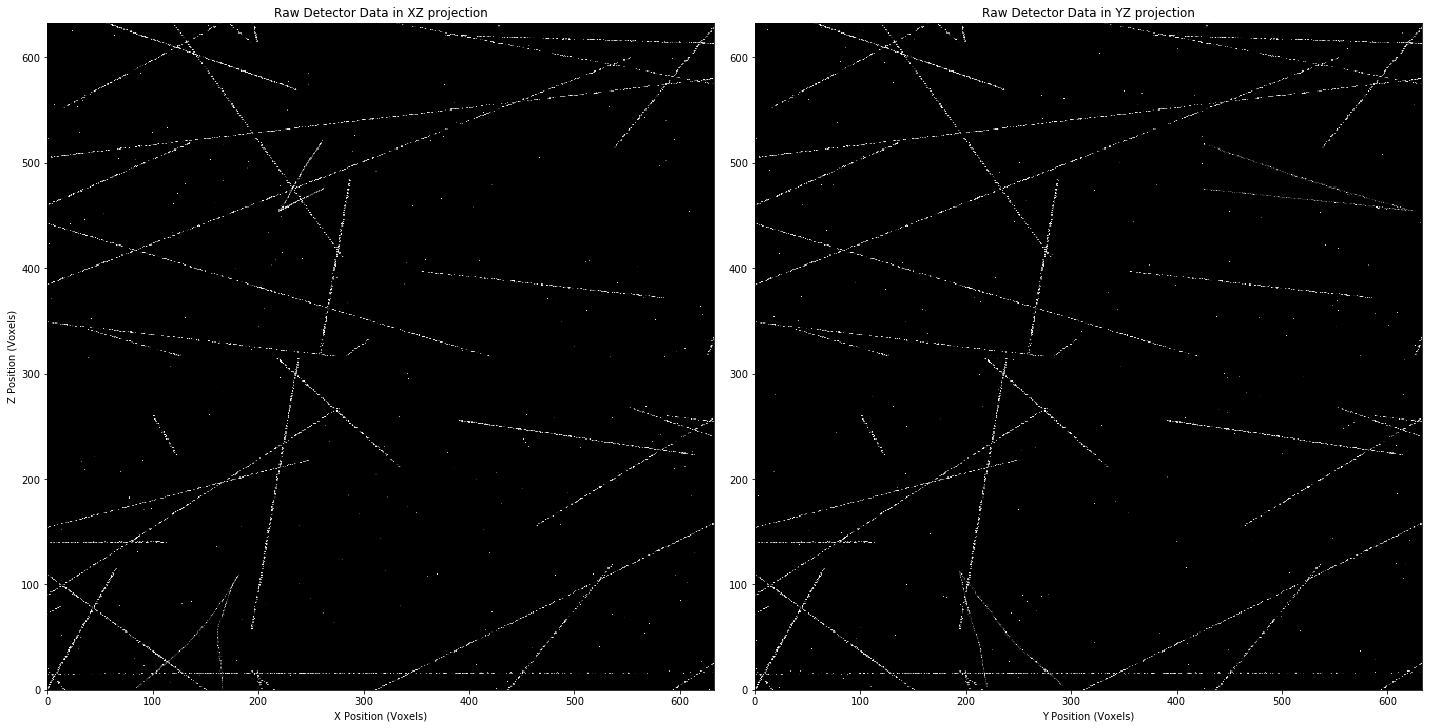

In [5]:
figure_raw, (ax_raw_XZ, ax_raw_YZ) = plt.subplots(1, 2, figsize=(20, 10))
cmap = Greys_9_r.mpl_colormap

# Brighten detector hits for display
if(mode == Mode.IMAGE):
    image_XZ = image_XZ * 10
    image_YZ = image_YZ * 10
if(mode == Mode.STREAM):
    for i in range(dimensions[2]):
        for j in range(dimensions[1]):
            image_XZ[i][j] = image_XZ[i][j] * 10
            image_YZ[i][j] = image_YZ[i][j] * 10

# Plot the raw images
ax_raw_XZ.imshow(image_XZ, origin = 'lower', cmap = cmap, interpolation = 'nearest')
ax_raw_YZ.imshow(image_YZ, origin = 'lower', cmap = cmap, interpolation = 'nearest')

# Set axis limits
ax_raw_XZ.set_xlim(0, columns_XZ)
ax_raw_XZ.set_ylim(0, rows_XZ)
ax_raw_YZ.set_xlim(0, columns_YZ)
ax_raw_YZ.set_ylim(0, rows_YZ)

# No grid
ax_raw_XZ.grid(False)
ax_raw_YZ.grid(False)

# Set labels
ax_raw_XZ.set_xlabel('X Position (Voxels)')
ax_raw_YZ.set_xlabel('Y Position (Voxels)')
ax_raw_XZ.set_ylabel('Z Position (Voxels)')

# Set titles
ax_raw_XZ.set_title('Raw Detector Data in XZ projection')
ax_raw_YZ.set_title('Raw Detector Data in YZ projection')

plt.tight_layout() # Spaces titles out properly

# Save figure 
file_raw_XZYZ ='Output/Raw_XZYZ.pdf'
plt.savefig(file_raw_XZYZ)
print('Saving raw image of detector hits to: ' + file_raw_XZYZ)

plt.show(figure_raw)

# Plot Detector Hits

Display reduced images to only contain hit locations. This is done to reduce structure complexity for image processing.

Saving image of detector hits to: Output/Hits_XZYZ.pdf


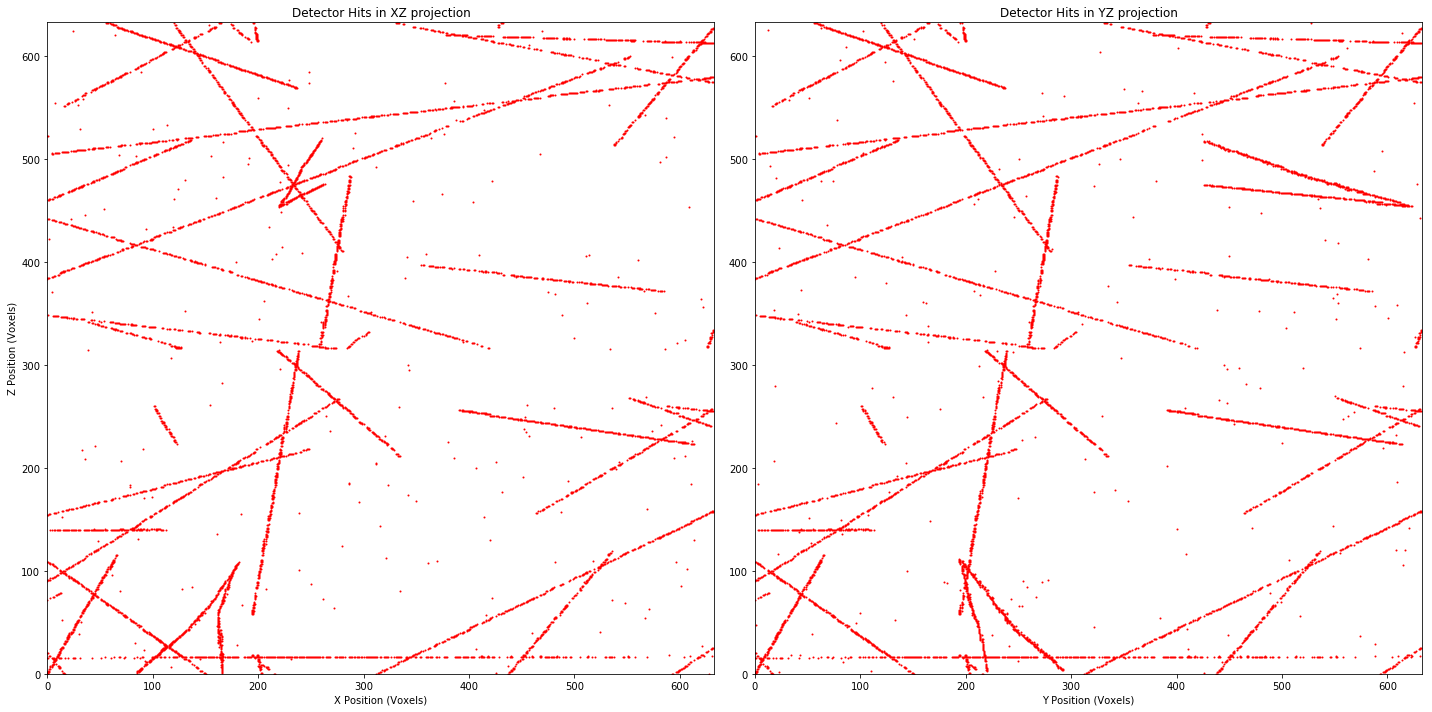

In [6]:
figure_hits, (ax_hits_XZ, ax_hits_YZ) = plt.subplots(1, 2, figsize=(20, 10))

# Plot detector hits
ax_hits_XZ.plot(hits_XZ[:,0], hits_XZ[:,1], '.', ms=2, color='red') 
ax_hits_YZ.plot(hits_YZ[:,0], hits_YZ[:,1], '.', ms=2, color='red')

# Set axis limits
ax_hits_XZ.set_xlim(0, columns_XZ)
ax_hits_XZ.set_ylim(0, rows_XZ)
ax_hits_YZ.set_xlim(0, columns_YZ)
ax_hits_YZ.set_ylim(0, rows_YZ)

# Set labels
ax_hits_XZ.set_xlabel('X Position (Voxels)')
ax_hits_YZ.set_xlabel('Y Position (Voxels)')
ax_hits_XZ.set_ylabel('Z Position (Voxels)')

# Set titles
ax_hits_XZ.set_title('Detector Hits in XZ projection')
ax_hits_YZ.set_title('Detector Hits in YZ projection')

plt.tight_layout() # Spaces titles out properly

# Save figure 
file_hits_XZYZ ='Output/Hits_XZYZ.pdf'
plt.savefig(file_hits_XZYZ)
print('Saving image of detector hits to: ' + file_hits_XZYZ)

plt.show(figure_hits)

# Build KD Tree of Detector Hits

KD trees are used to represent sparse image data more effectively, and allow for rapid nearest neighbour searches.
Nearest neighbour (NN) searches are used extensively throughout this software, which is why KD trees were chosen as the search structure for the detector data. That being said, should this software be implemented in C, it may be beneficial to implement and optimize a quadtree, as this structure may improve performance.

In [7]:
# Insert XZ hits and YZ hits into repective KD trees
tree_XZ = cKDTree(hits_XZ, leafsize=15)
tree_YZ = cKDTree(hits_YZ, leafsize=15)

# Remove Noise from Detector Hits

Several detector hits will be noise intrinsic to the gaseous volume, and so will need to be removed. This is done by performing a nearest neighbour search on all points to determine if a sufficient number of nearest neighbours borders the point being analyzed.

In [8]:
clean_hits_XZ = []
clean_hits_YZ = []

# Filter XZ Projection
for i in range(len(hits_XZ)):
    current_hit_NN = hits_XZ[tree_XZ.query_ball_point(hits_XZ[i], 4)]
    
    # Add point if there are more than 2 nearest neighbours
    if(len(current_hit_NN) > 2):
        clean_hits_XZ.append(hits_XZ[i])

# Filter YZ Projection
for i in range(len(hits_YZ)):
    current_hit_NN = hits_YZ[tree_YZ.query_ball_point(hits_YZ[i], 4)]
    
    # Add point if there are more than 2 nearest neighbours
    if(len(current_hit_NN) > 2):
        clean_hits_YZ.append(hits_YZ[i])
        
# Set filtered hits
hits_XZ = clean_hits_XZ
hits_YZ = clean_hits_YZ

# Convert to numpy array
hits_XZ = np.array(hits_XZ)
hits_YZ = np.array(hits_YZ)

# Sort first by lowest Z coordinate, then by lowest position coordinate
hits_XZ = hits_XZ[np.lexsort((hits_XZ[:, 0], hits_XZ[:, 1]))]
hits_YZ = hits_YZ[np.lexsort((hits_YZ[:, 0], hits_YZ[:, 1]))]

# Remake KD trees
tree_XZ = cKDTree(hits_XZ, leafsize=15)
tree_YZ = cKDTree(hits_YZ, leafsize=15)

# Plot Detector Hits with Noise Removed

Saving image of filtered detector hits to: Output/Filtered_Hits_XZYZ.pdf


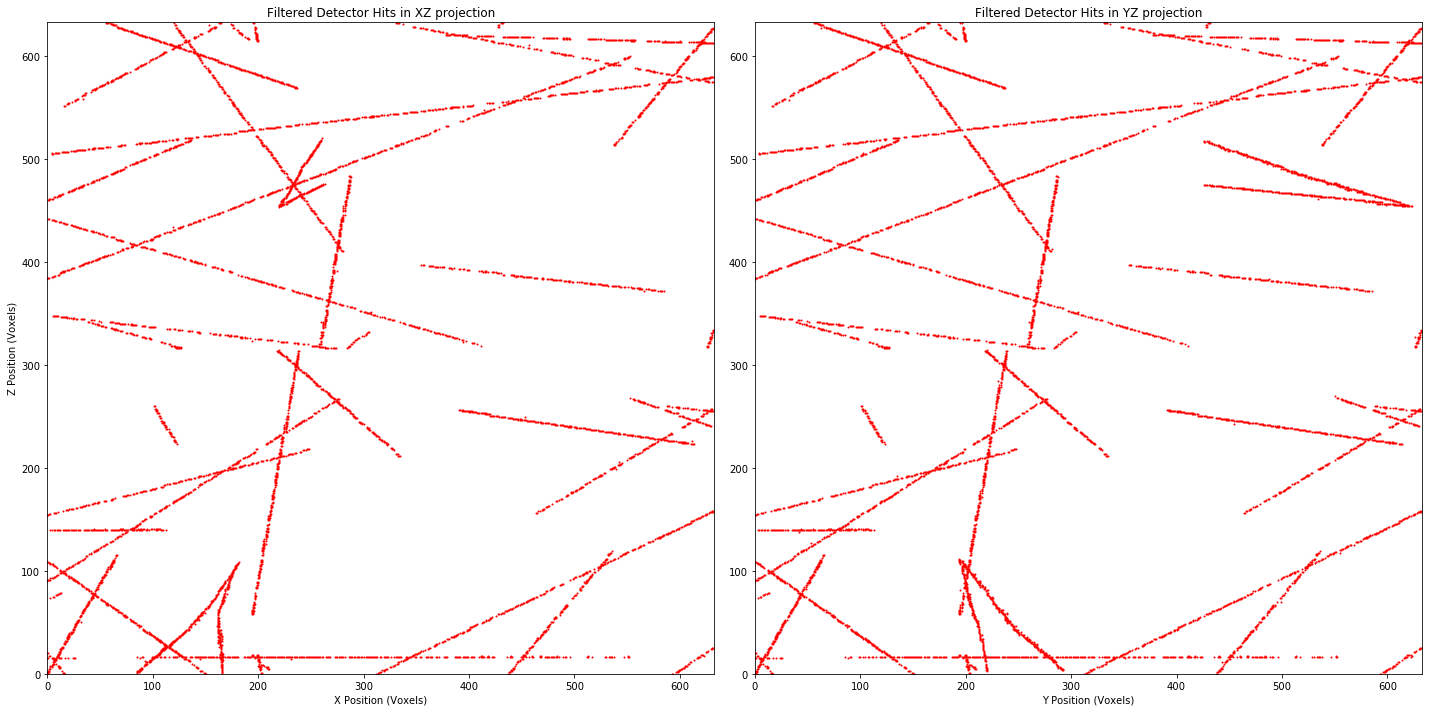

In [9]:
figure_filtered_hits, (ax_filtered_hits_XZ, ax_filtered_hits_YZ) = plt.subplots(1, 2, figsize=(20, 10))

# Plot the detector hits
ax_filtered_hits_XZ.plot(hits_XZ[:,0], hits_XZ[:,1], '.', ms=2, color='red') 
ax_filtered_hits_YZ.plot(hits_YZ[:,0], hits_YZ[:,1], '.', ms=2, color='red')

# Set axis limits
ax_filtered_hits_XZ.set_xlim(0, columns_XZ)
ax_filtered_hits_XZ.set_ylim(0, rows_XZ)
ax_filtered_hits_YZ.set_xlim(0, columns_YZ)
ax_filtered_hits_YZ.set_ylim(0, rows_YZ)

# Set labels
ax_filtered_hits_XZ.set_xlabel('X Position (Voxels)')
ax_filtered_hits_YZ.set_xlabel('Y Position (Voxels)')
ax_filtered_hits_XZ.set_ylabel('Z Position (Voxels)')

# Set titles
ax_filtered_hits_XZ.set_title('Filtered Detector Hits in XZ projection')
ax_filtered_hits_YZ.set_title('Filtered Detector Hits in YZ projection')

plt.tight_layout() # Spaces titles out properly

# Save figure 
file_filtered_hits_XZYZ ='Output/Filtered_Hits_XZYZ.pdf'
plt.savefig(file_filtered_hits_XZYZ)
print('Saving image of filtered detector hits to: ' + file_filtered_hits_XZYZ)

plt.show(figure_filtered_hits)

# Find Track Terminating Points

To begin searching for straight and shallow curve tracks, finding track terminating points reduces the number of detector hits to be searched along. These terminating points are the end points and outliers in each of the projections. Outliers will be filtered out later in the software, as they cannot be classified as outliers at this stage.

It should also be noted that upon displaying terminating points, one can see that there are several terminating points located within close proximity to each other. These points will produce different, but similar tracks, which will eventually be merged if each track shares enough similar points with another track. This improves the track-point coverage, thereby decreasing the chances that points belonging to a track are missed.

In [10]:
# Function to calculate the angle between two neighbouring track segments
#
# Expects two numpy ndarrays [proj_i z_i proj_f z_f] where:
# proj_i - starting x/y coordinate
# z_i    - starting z coordinate
# proj_f - final x/y coordinate
# z_f    - final z coordinate
def calcTrackSegmentAngle(segA, segB):
    # Create vectors
    vA = [(segA[2] - segA[0]), (segA[3] - segA[1])]
    vB = [(segB[2] - segB[0]), (segB[3] - segB[1])]
    
    # Calculate the dot product between the vectors
    dotvAvB = np.dot(vA, vB)
    
    # Calculate the magnitude of each vector
    magA = np.dot(vA, vA)**0.5
    magB = np.dot(vB, vB)**0.5
    
    # Return the angle in degrees
    if(magA != 0 and magB != 0):
        return np.degrees(np.arccos(dotvAvB/(magA*magB)))
    else:
        return 0 # Vectors have the same direction

In [11]:
# Finds terminating points for straight and shallow curve tracks
# Expects a list of detector hits, a hit KD tree, and the type of projection (XZ/YZ)
def findTerminatingPoints(hits_proj, tree_proj, type_proj):
    # Radii bounds
    radius_minimum = 10
    radius_maximum = 20
    radius_step = 1
    
    accept_angle = 30       # Acceptance angle for segments similar to heading (+/- degrees)
    reject_angle = 120      # Rejection angle for segments disimilar to heading (+/- degrees)
    terminating_points = [] # List to store terminating points
    
    # Loop through each detector hit to check whether it is a terminating point or not
    for i in range(len(hits_proj)):
        current_hit_NN = []            # Reset nearest neighbours to empty list
        heading_point_groups = []      # Groups of candidate points; Largest group belongs to heading
        length = 0                     # Length of largest heading candidate point group
        search_radius = radius_minimum # Reset search radius to minimum
        proj_heading = 0               # Projection coordinate of the current heading
        z_heading = 0                  # Z coordinate of the current heading
        bounded_points = 0             # Counter for number of nearest neighbours within heading acceptance angle
        reject = False                 # Rejection flag
        
        # Until there are at least 10 nearest neighbours, determining terminating points will be ineffective
        while(len(current_hit_NN) < 10):
            # Find nearest neighbours to use in constructing the heading
            current_hit_NN = hits_proj[tree_proj.query_ball_point(hits_proj[i], search_radius)]
            search_radius += radius_step # Increment search radius
            
            # Insufficient nearest neighbours found
            if(search_radius > radius_maximum):
                break
        
        # Found enough nearest neighbours
        if(len(current_hit_NN) >= 10):
            # Build a group of like-segments for each nearest neighbour
            for(proj_NN, z_NN) in current_hit_NN:
                current_point_group = []                                                  # Current group of heading candidate points
                current_point_group.append(np.array([proj_NN, z_NN]))                     # Add current primary point to current point group
                primary_seg = np.array([hits_proj[i][0], hits_proj[i][1], proj_NN, z_NN]) # Segment to use against other segments to find angle
                
                # Compare current segment against other segments
                for(proj_compare, z_compare) in current_hit_NN:
                    if((proj_NN != proj_compare) and (z_NN != z_compare)):
                        # Current comparing segment
                        compare_seg = np.array([hits_proj[i][0], hits_proj[i][1], proj_compare, z_compare])

                        # Angle between primary segment and current segment is within acceptace
                        # Add compare point to primary point group
                        angle = calcTrackSegmentAngle(primary_seg, compare_seg)
                        if(angle < accept_angle):
                            current_point_group.append(np.array([proj_compare, z_compare]))
                        if(angle > reject_angle):
                            reject = True
                            break
                
                    heading_point_groups.append(current_point_group) # Add current group of points into total collection of point groups

                # Angle disimilar
                if(reject == True):
                    reject = False
                    break
                
            # Find largest heading group
            for j in range(len(heading_point_groups)):
                if(len(heading_point_groups[j]) > length):
                    length = len(heading_point_groups[j])
                    index = j

            # Construct heading 
            for j in range(len(heading_point_groups[index])):
                proj_heading += heading_point_groups[index][j][0]
                z_heading += heading_point_groups[index][j][1]
            proj_heading = proj_heading / len(heading_point_groups[index])                  # Averaged projection coordinate
            z_heading = z_heading / len(heading_point_groups[index])                        # Averaged z coordinate
            heading = np.array([hits_proj[i][0], hits_proj[i][1], proj_heading, z_heading]) # Heading segment
            
            # Count number of nearest neighbours within acceptance of heading
            for(proj_NN, z_NN) in current_hit_NN:
                compare_seg = np.array([hits_proj[i][0], hits_proj[i][1], proj_NN, z_NN]) # Current segment
                if(calcTrackSegmentAngle(heading, compare_seg) < accept_angle):
                    bounded_points += 1
                    
            # If number of bounded points is above threshold, current point is terminating
            if(bounded_points >= 0.85 * len(current_hit_NN)):
                terminating_points.append(hits_proj[i])
    
    # Filter terminating points so no two are too close together
    filtered_points = [terminating_points[0]]
    for i in range(1, len(terminating_points)):
        good = True
        for j in range(len(filtered_points)):
            term_NN = hits_proj[tree_proj.query_ball_point(filtered_points[j], 2)]
            if(terminating_points[i] in term_NN):
                distance = sqrt((terminating_points[i][0] - filtered_points[j][0])**2 + 
                                (terminating_points[i][1] - filtered_points[j][1])**2)
                # Too close; Scrap this point
                if(distance < 10):
                    good = False
        if(good == True):
            filtered_points.append(terminating_points[i])
            
    terminating_points = filtered_points # Set terminating points to filtered set
    
    # Format terminating point list
    terminating_points = np.vstack({tuple(row) for row in terminating_points})
    print('Number of starting / ending points in ', type_proj, 'projection: [', len(terminating_points), ']')
    
    return terminating_points

In [12]:
terminate_XZ = findTerminatingPoints(hits_XZ, tree_XZ, 'XZ')
terminate_YZ = findTerminatingPoints(hits_YZ, tree_YZ, 'YZ')

C:\Users\deevy\Miniconda3\envs\AdEPT\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in arccos


Number of starting / ending points in  XZ projection: [ 71 ]
Number of starting / ending points in  YZ projection: [ 71 ]


# Plot Track Source Points

Saving image of terminating points to: Output/Terminating_Points_XZYZ.pdf


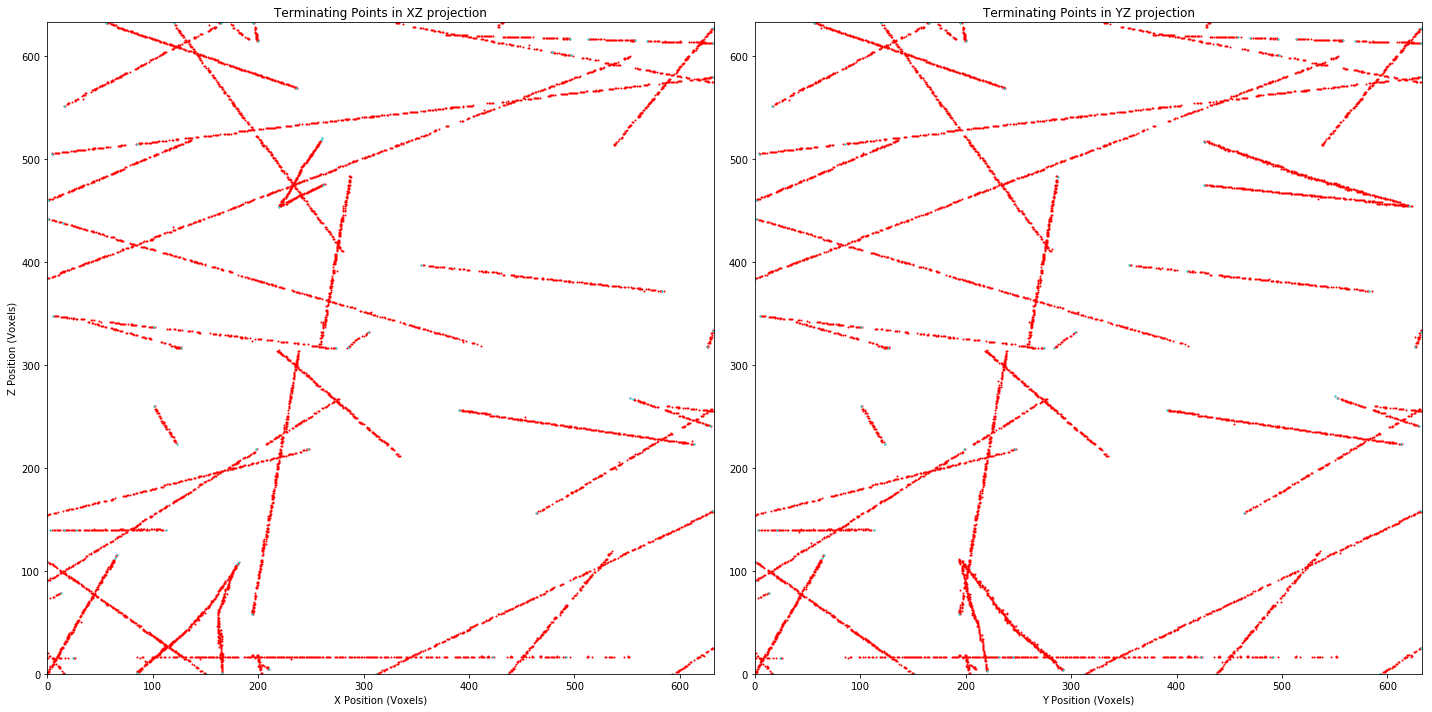

In [13]:
figure_terminate, (ax_terminate_XZ, ax_terminate_YZ) = plt.subplots(1, 2, figsize=(20, 10))

# Plot the detector hits and terminating points
ax_terminate_XZ.plot(hits_XZ[:,0], hits_XZ[:,1], '.', ms=2, color='red') 
ax_terminate_YZ.plot(hits_YZ[:,0], hits_YZ[:,1], '.', ms=2, color='red')
ax_terminate_XZ.plot(terminate_XZ[:,0], terminate_XZ[:,1], '.', ms=2, color='cyan') 
ax_terminate_YZ.plot(terminate_YZ[:,0], terminate_YZ[:,1], '.', ms=2, color='cyan') 

# Set axis limits
ax_terminate_XZ.set_xlim(0, columns_XZ)
ax_terminate_XZ.set_ylim(0, rows_XZ)
ax_terminate_YZ.set_xlim(0, columns_YZ)
ax_terminate_YZ.set_ylim(0, rows_YZ)

# Set labels
ax_terminate_XZ.set_xlabel('X Position (Voxels)')
ax_terminate_YZ.set_xlabel('Y Position (Voxels)')
ax_terminate_XZ.set_ylabel('Z Position (Voxels)')

# Set titles
ax_terminate_XZ.set_title('Terminating Points in XZ projection')
ax_terminate_YZ.set_title('Terminating Points in YZ projection')

plt.tight_layout() # Spaces titles out properly

# Save figure 
file_terminate_XZYZ ='Output/Terminating_Points_XZYZ.pdf'
plt.savefig(file_terminate_XZYZ)
print('Saving image of terminating points to: ' + file_terminate_XZYZ)

plt.show(figure_terminate)

# Partial Track Generation

Partial track generation utilizes track traversal via a cellular automaton + terminating point based approach, as well as a linear least squares approximation based approach. Several of these partial tracks will overlap, and will be merged in code modules following this one. It should be noted that this module can take extensive amounts of time to traverse all tracks, and that the time required to complete this modue scales at an O(N) rate with the number of detector hits.

**Cellular Automaton + Terminating Point Traversal**

Starting at a terminating point, an initial heading is constructed out of the largest group of similar nearest neighbours, and a 'farthest point' is found with an upper distance bound placed on it to improve track coverage at close range. Following this, the heading is moved to the farthest point, and a new heading is constructed out of nearest neighbours around that new point, such that those points are within an acceptable angle to the original heading. This process is repeated until there are no additional nearest neighbours that fit within the heading, thereby reching the end of the track.

**Linear Least Squares Traversal**

As some tracks may not be fully traversed in the aforementioned traversal method, this secondary method is used to detect remaining partial tracks. Lineare least squares method takes remaining untracked points, performs a nearet neighbour search at a large distance, and fits a line to the points. If sufficiently close, the line can be said to be a part of a track. From here, all points along the line will be added as a partial track, and the points contained within are removed from the untracked points list. This process repeats until negligible untracked points remain.

In [14]:
# Finds partial tracks by starting from terminating points, and traversing similar neighbours
# Expects a list of detector hits, a hit KD tree, and the type of projection (XZ/YZ)
def findPartialTracks(hits_proj, term_proj, tree_proj, proj_type):
    # Cellular Automaton / Terminating Point Traversal Method ----------------------------------------------
    
    radius_minimum = 5      # Minimum search radius
    radius_maximum = 20     # Maximum search radius
    radius_step = 1         # Step at which to increase search radius
    
    accept_angle = 30       # Acceptance angle for segments similar to heading (+/- degrees)
    reject_angle = 120      # Rejection angle for segments disimilar to heading (+/- degrees)
    
    partial_tracks = []     # List to store partial tracks
    covered_points = []     # List of points covered by terminating point traversal
    uncovered_points = []   # List of points not covered by terminating point traversal
    
    # Generate a partial track for each terminating point in the projection
    for (proj, z) in term_proj:
        search_radius = radius_minimum # Reset search radius to minimum
        heading_NN = []                # Reset nearest neighbours to empty list
        
        # Until there are at least 10 nearest neighbours, heading will be ineffective
        while(len(heading_NN) < 10):
            # Find nearest neighbours to use in constructing the heading
            heading_NN = hits_proj[tree_proj.query_ball_point([proj, z], search_radius)]
            search_radius += radius_step # Increment search radius
            
            # No nearest neighbours found
            if(search_radius > radius_maximum):
                break
        
        # Found enough nearest neighbours to traverse track
        if(len(heading_NN) >= 10):
            max_group_length = 0      # Length of the largest heading point group
            max_group_index = 0       # Index of the largest heading point group
            
            heading_point_groups = [] # List used to store groups of points used to determine heading
            partial_track_points = [] # List used to store points contained in the partial track
            
            # Make a group of similar points for each nearest neighbour
            for (proj_NN, z_NN) in heading_NN:
                current_point_group = [np.array([proj_NN, z_NN])]  # Initialize current point group
                reference_seg = np.array([proj, z, proj_NN, z_NN]) # Reference segment; Used to find similar points
                
                # Check reference point against all other nearest neighbours
                for (proj_comp, z_comp) in heading_NN:
                    if(proj_NN != proj_comp and z_NN != z_comp):
                        compare_seg = np.array([proj, z, proj_comp, z_comp]) # Current comparing segment
                        
                        # Angle between reference segment and compare segment is within acceptace
                        # Add compare point to reference point group
                        if(calcTrackSegmentAngle(reference_seg, compare_seg) <= accept_angle):
                            current_point_group.append(np.array([proj_comp, z_comp]))
                            
                heading_point_groups.append(current_point_group) # Add point group to list of point groups
                
            # Find largest heading group
            for i in range(len(heading_point_groups)):
                if(len(heading_point_groups[i]) > max_group_length):
                    max_group_length = len(heading_point_groups[i])
                    max_group_index = i
                    
            # Add heading points to partial track points list and current heading points list 
            partial_track_points.extend(heading_point_groups[max_group_index])
            
            # Set up variables for track traversal
            start_point = np.array([proj, z])                      # Point at which heading was created
            heading_points = heading_point_groups[max_group_index] # Points contained in the heading
            
            first_pass = True # Initial heading pass flag
            pass_counter = 0  # Counter to ensure a track doesn't get stuck in an infinite loop; Track will be discarded
            
            # Traverse track until no points are found within heading
            while(len(heading_points) > 0):
                farthest_distance = 0             # Distance of farthest point relative to start point
                farthest_point = [0, 0]           # Reset farthest point variable as placeholder; Will be overwritten
                proj_heading = 0                  # Projection coordinate of heading terminating point
                z_heading = 0                     # Z coordinate of heading terminating point
                
                pass_counter += 1 # Increment counter
                
                # Break out of infinite looping track
                if(pass_counter >= 1000):
                    break
                
                # Find farthest heading point; Check each heading point against start point
                for (proj_far, z_far) in heading_points:
                    distance = sqrt((start_point[0] - proj_far)**2 + (start_point[1] - z_far)**2) # Current distance
                    if(distance > farthest_distance and distance < 7.5):
                        farthest_distance = distance
                        farthest_point = [proj_far, z_far]
                        
                # Construct heading from averaged heading points
                for (proj_head, z_head) in heading_points:
                    proj_heading += proj_head
                    z_heading += z_head
                proj_heading /= len(heading_points) # Averaged heading terminating point projection coordinate; Start
                z_heading /= len(heading_points)    # Averaged heading terminating point z coordinate; Start
                
                proj_heading = proj_heading + farthest_point[0] - start_point[0] # Heading projection coordinate; End 
                z_heading = z_heading + farthest_point[1] - start_point[1]       # Heading z coordinate; End
                
                # Construct averaged heading point
                if(first_pass == True):
                    first_pass = False
                    heading = np.array([farthest_point[0], farthest_point[1], proj_heading, z_heading])
                    original_heading = heading # Used to ensure future points don't veer too far off original heading
                    bounded_heading = original_heading
                else:
                    heading = np.array([(farthest_point[0] * 2 + heading[0] * 3) / 5,
                                        (farthest_point[1] * 2 + heading[1] * 3) / 5,
                                        (proj_heading * 2 + heading[2] * 3) / 5,
                                        (z_heading * 2 + heading[3] * 3) / 5])
                    bounded_heading = np.array([heading[0],
                                                heading[1],
                                                (original_heading[2] - original_heading[0]) + heading[0],
                                                (original_heading[3] - original_heading[1]) + heading[1]])
                
                # Find nearest neighbours around farthest point to construct next heading
                search_radius = radius_maximum # Set search radius to maximum; Covers track in less steps
                heading_NN = []                # Reset nearest neighbours to empty list
                heading_points = []            # Reset heading points
                
                heading_NN = hits_proj[tree_proj.query_ball_point([heading[0], heading[1]], search_radius)]

                # Found nearest nearest neighbours to check against heading
                if(len(heading_NN) > 0):
                    # Check each nearest neighbour against heading; Accept if within heading acceptance angle
                    for (proj_comp, z_comp) in heading_NN:
                        compare_seg = np.array([heading[0], heading[1], proj_comp, z_comp]) # Current segment

                        if(calcTrackSegmentAngle(heading, compare_seg) < accept_angle/2):
                            if(first_pass == False and calcTrackSegmentAngle(bounded_heading, compare_seg) < 30):
                                heading_points.append(np.array([proj_comp, z_comp])) # Add heading point to list
                            if(first_pass == True):
                                heading_points.append(np.array([proj_comp, z_comp])) # Add heading point to list
                                
                start_point = farthest_point # Set next start point to current farthest point
                
                # Add heading points to partial track points
                partial_track_points.extend(heading_points)
                
        # If unlikely for looping track, and track is long enough append partial track
        if(pass_counter < 1000 and len(partial_track_points) > 5):       
            partial_tracks.append(partial_track_points) # Add partial track to partial tracks list
            covered_points.extend(partial_track_points) # Add points covered by terminating point traversal
    
    # Linear Least Squares Traversal Method ----------------------------------------------------------------
    
    # Points covered by previous traversal method
    covered_points = np.vstack(covered_points)
    covered_points = np.vstack({tuple(row) for row in covered_points})
    covered_points = covered_points.tolist()
    
    # Find uncovered points
    for i in range(len(hits_proj)):
        covered = False
        for j in range(len(covered_points)):
            if((hits_proj[i][0] == covered_points[j][0]) and (hits_proj[i][1] == covered_points[j][1])):
                covered = True
                break # Point has been covered
        # Add uncovered point to list
        if(covered == False):
            uncovered_points.append(hits_proj[i])
            
    # Find partial tracks amongst uncovered points by linear least squares approximation
    potential_partial_track = True
    while(potential_partial_track == True):
        
        # Uncomment the following line for confirmation of module working (NOTE: Will still require time to show results)
        #print('Length of uncovered points list:', len(uncovered_points))
        for (uncovered_proj, uncovered_z) in uncovered_points:
            potential_partial_track = True
            uncovered_NN = hits_proj[tree_proj.query_ball_point([uncovered_proj, uncovered_z], 2*radius_maximum)]
            if(len(uncovered_NN) > 10):
                # Compute LLS approximation to uncovered points
                rise = 0 # Rise portion of slope of line
                run = 0  # Run portion of slope of line
                proj_mean = uncovered_z 
                z_mean = uncovered_proj 
                for j in range(len(uncovered_NN)):
                    proj_mean += uncovered_NN[j][0]
                    z_mean += uncovered_NN[j][1]
                proj_mean /= (len(uncovered_NN) + 1)
                z_mean /= (len(uncovered_NN) + 1)

                for j in range(len(uncovered_NN)):
                    rise += ((uncovered_NN[j][0] - proj_mean) * (uncovered_NN[j][1] - z_mean))
                    run += (uncovered_NN[j][0] - proj_mean)**2     

                # Line equation parameters
                slope = rise / run
                z_intercept = z_mean - (slope * proj_mean)

                # Find distance between each nearest neighbour and line
                for j in range(len(uncovered_NN)):
                    inverse_intercept = uncovered_NN[j][1] - ((-1/slope)*uncovered_NN[j][0])
                    line_proj = (inverse_intercept - z_intercept) / (slope + 1/slope)
                    line_z = slope*line_proj + z_intercept
                    distance = sqrt((uncovered_NN[j][0] - line_proj)**2 + (uncovered_NN[j][1] - line_z)**2)

                    # Points too far, not a good candidate partial track location
                    if(distance > 25):
                        potential_partial_track = False
                        break

                # Track still good
                if(potential_partial_track == True):
                    partial_track_points = [] # Empty partial track list

                    # Check uncovered points for similarity
                    for (new_proj, new_z) in uncovered_points:
                        z_check = slope * new_proj + z_intercept

                        # Similar enough, add to track
                        if(abs(z_check - new_z) < 250):
                            partial_track_points.append(np.array([new_proj, new_z]))
                    if(len(partial_track_points) > 0):          
                        # Add new partial track
                        partial_tracks.append(partial_track_points) # Add partial track to partial tracks list
                        covered_points.extend(partial_track_points) # Add points covered by terminating point traversal

                    # Recreate uncovered points list
                    new_uncovered_points = []
                    for j in range(len(uncovered_points)):
                        covered = False
                        for k in range(len(partial_track_points)):
                            if(uncovered_points[j][0] == partial_track_points[k][0] and 
                              uncovered_points[j][1] == partial_track_points[k][1]):
                                covered = True
                                break
                        if(covered == False):
                            new_uncovered_points.append(uncovered_points[j])
                    
                    # Reset to new uncovered points list and break out of loop to reset uncovered point traversal
                    uncovered_points = new_uncovered_points
                    break
        
        # If no remaining uncovered points, break out of outer loop
        if(len(uncovered_points) == 0):
            break
                    
    # Format partial tracks
    for i in range(len(partial_tracks)):
        partial_tracks[i] = np.vstack(partial_tracks[i])
        partial_tracks[i]= np.vstack({tuple(row) for row in partial_tracks[i]})
    
    # Print out some useful information
    print('Number of', proj_type, 'partial tracks:', len(partial_tracks))
    
    return partial_tracks

In [15]:
# Find XZ and YZ initial track segments
partial_tracks_XZ = findPartialTracks(hits_XZ, terminate_XZ, tree_XZ, 'XZ')
partial_tracks_YZ = findPartialTracks(hits_YZ, terminate_YZ, tree_YZ, 'YZ')

C:\Users\deevy\Miniconda3\envs\AdEPT\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in arccos


Number of XZ partial tracks: 68
Number of YZ partial tracks: 65


# Plot Partial Track Coverage

Saving image of partial tracks to: Output/Partial_Tracks_XZYZ.pdf


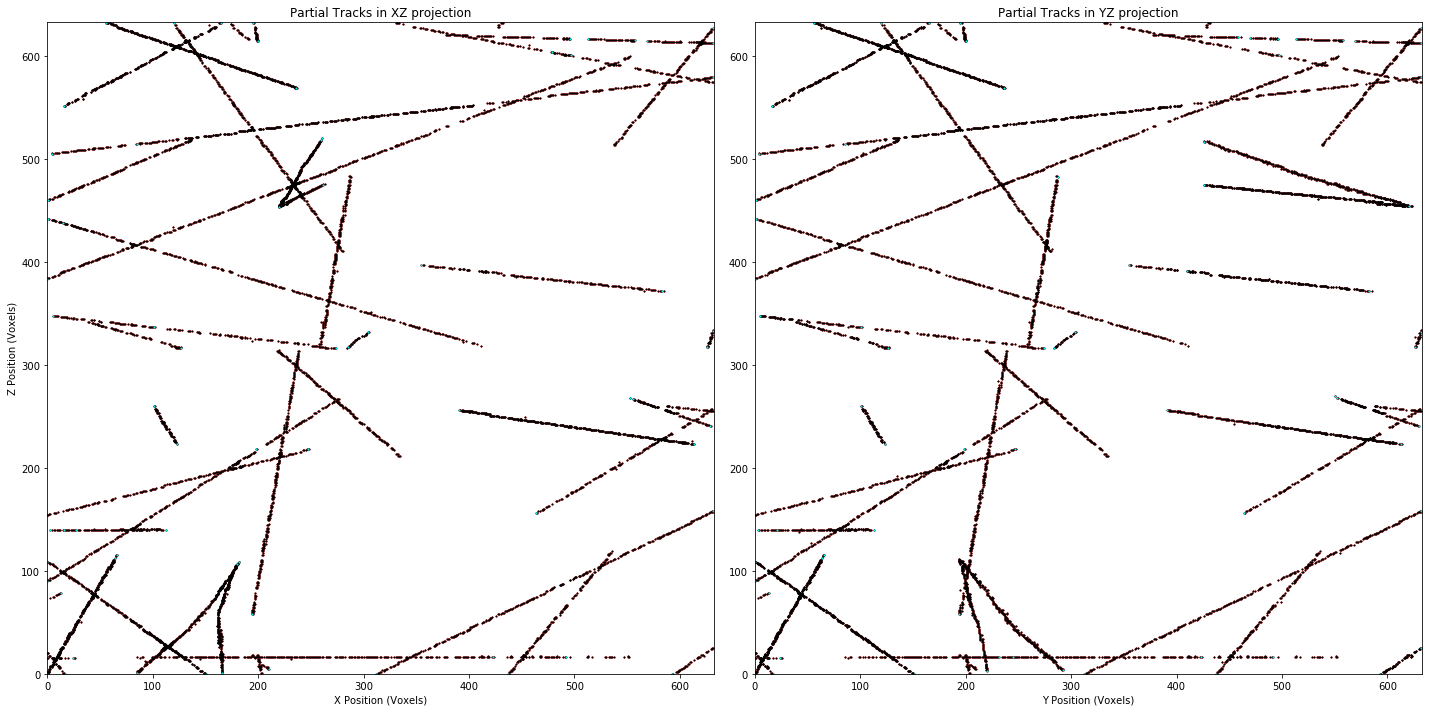

In [16]:
figure_partial_tracks, (ax_partial_tracks_XZ, ax_partial_tracks_YZ) = plt.subplots(1, 2, figsize=(20, 10))

# Plot the detector hits
ax_partial_tracks_XZ.plot(hits_XZ[:,0], hits_XZ[:,1], '.', ms=2, color='red') 
ax_partial_tracks_YZ.plot(hits_YZ[:,0], hits_YZ[:,1], '.', ms=2, color='red')

# Plot track hits
for i in range(len(partial_tracks_XZ)):
    ax_partial_tracks_XZ.plot(partial_tracks_XZ[i][:,0], partial_tracks_XZ[i][:,1], '.', ms=2, color='black')
for i in range(len(partial_tracks_YZ)):
    ax_partial_tracks_YZ.plot(partial_tracks_YZ[i][:,0], partial_tracks_YZ[i][:,1], '.', ms=2, color='black')

# Plot terminating points
ax_partial_tracks_XZ.plot(terminate_XZ[:,0], terminate_XZ[:,1], '.', ms=2, color='cyan')
ax_partial_tracks_YZ.plot(terminate_YZ[:,0], terminate_YZ[:,1], '.', ms=2, color='cyan')

# Set axis limits
ax_partial_tracks_XZ.set_xlim(0, columns_XZ)
ax_partial_tracks_XZ.set_ylim(0, rows_XZ)
ax_partial_tracks_YZ.set_xlim(0, columns_YZ)
ax_partial_tracks_YZ.set_ylim(0, rows_YZ)

# Set labels
ax_partial_tracks_XZ.set_xlabel('X Position (Voxels)')
ax_partial_tracks_YZ.set_xlabel('Y Position (Voxels)')
ax_partial_tracks_XZ.set_ylabel('Z Position (Voxels)')

# Set titles
ax_partial_tracks_XZ.set_title('Partial Tracks in XZ projection')
ax_partial_tracks_YZ.set_title('Partial Tracks in YZ projection')

plt.tight_layout() # Spaces titles out properly

# Save figure 
file_partial_tracks_XZYZ ='Output/Partial_Tracks_XZYZ.pdf'
plt.savefig(file_partial_tracks_XZYZ)
print('Saving image of partial tracks to: ' + file_partial_tracks_XZYZ)

plt.show(figure_partial_tracks)

# Combine Partial Tracks to Improve Full Track Coverage

As different start points may result in slight deviations in track coverage, it is possible that two or more partial tracks are actually part of the same track. The following code analyzes partial tracks near the current partial track to check for similarities between the two. If they are sufficiently similar, we can consider them a single full track, and so we merge them. 

In [17]:
# Function to combine partial tracks with enough overlap into a single track
def combinePartialTracks(tracks_proj, hits_proj, tree_proj, proj_type):
    tracks = []    # List to store full length tracks
    completed = [] # List of indices of completed tracks

    # Loop through each track and each point in the forward successesion for overlap
    for i in range(len(tracks_proj)):
        merged = False                         # Flag for whether the track was merged with another or not
        reference_length = len(tracks_proj[i]) # Length of reference track
        
        # If current track not in completed, then it hasn't been merged with another yet
        if(i not in completed):      
            start_match = False # Start of reference similar flag
            end_match = False   # End of reference similar flag
            
            # Nearest neighbours around start and end of reference track; Used to locate nearby comparable tracks
            start_NN = hits_proj[tree_proj.query_ball_point([tracks_proj[i][0][0], tracks_proj[i][0][1]], 5)]
            end_NN = hits_proj[tree_proj.query_ball_point([tracks_proj[i][-1][0], tracks_proj[i][-1][1]], 5)]
            
            # Check every other track within range against current candidate
            for j in range(len(tracks_proj)):
                similar_counter = 0   # Reset similar counter
                disimilar_counter = 0 # Reset disimilar counter
                
                # Check tracks in the forward direction
                if(j > i):
                    compare_length = len(tracks_proj[j]) # Length of compare track
                    
                    # Check start of reference track for similarities
                    for (proj_NN, z_NN) in start_NN:
                        if((tracks_proj[j][0][0] == proj_NN and tracks_proj[j][0][1] == z_NN) or
                          (tracks_proj[j][-1][0] == proj_NN and tracks_proj[j][-1][1] == z_NN)):
                            start_match = True
                            
                    # Check end of reference track for similarities
                    for (proj_NN, z_NN) in end_NN:
                        if((tracks_proj[j][0][0] == proj_NN and tracks_proj[j][0][1] == z_NN) or
                          (tracks_proj[j][-1][0] == proj_NN and tracks_proj[j][-1][1] == z_NN)):
                            end_match = True
                            
                    # Found a similar endpoint
                    if(start_match == True or end_match == True):
                        
                        # Loop through all of the points for comparisions
                        for k in range(reference_length):
                            similar = False
                            for l in range(compare_length):
                                if(tracks_proj[i][k][0] == tracks_proj[j][l][0] and tracks_proj[i][k][1] == tracks_proj[j][l][1]):
                                    similar_counter += 1
                                    similar = True
                                    break
                            
                            # Not in compare track; Increase disimilar counter
                            if(similar == False):
                                disimilar_counter += 1
                                
                            # If disimilar counter greater than 20% length of both tracks' lengths, break
                            if(disimilar_counter > 0.2*reference_length and disimilar_counter > 0.2*compare_length):
                                break

                    # Tracks sufficiently overlap; Merge tracks
                    if(similar_counter > 0.8*reference_length or similar_counter > 0.8*compare_length):
                        merged_track = tracks_proj[i].tolist()
                        merged_track.append(tracks_proj[j])
                        
                        tracks.append(merged_track)
                        completed.append(j)
                        merged = True
                        
            # Unique track, add to final track list
            if(merged == False):
                tracks.append(tracks_proj[i].tolist())

    # Format partial tracks
    for i in range(len(tracks)):
        tracks[i] = np.vstack(tracks[i])
        tracks[i]= np.vstack({tuple(row) for row in tracks[i]})

    # Reorganize tracks so that start and end points are at the start and end of the track list
    for i in range(len(tracks)):
        max_distance = 0
        for j in range(len(tracks[i])):
            for k in range(len(tracks[i])):
                if(k > j):
                    distance = sqrt((tracks[i][j][0] - tracks[i][k][0])**2 + (tracks[i][j][1] - tracks[i][k][1])**2)
                    if(distance > max_distance):
                        max_distance = distance
                        start_point = tracks[i][j]
                        end_point = tracks[i][k]
        temp_track = tracks[i]
        tracks[i] = [start_point]
        tracks[i].append(temp_track)
        tracks[i].append(end_point)

    # Format partial tracks
    for i in range(len(tracks)):
        tracks[i] = np.vstack(tracks[i])
        
    # Output some useful information
    print('Number of', proj_type, 'tracks:', len(tracks))

    return tracks

In [18]:
tracks_XZ = combinePartialTracks(partial_tracks_XZ, hits_XZ, tree_XZ, 'XZ')
tracks_YZ = combinePartialTracks(partial_tracks_YZ, hits_XZ, tree_XZ, 'YZ')

Number of XZ tracks: 61
Number of YZ tracks: 57


# Plot Full Track Coverage

Saving image of tracks to: Output/Tracks_XZYZ.pdf


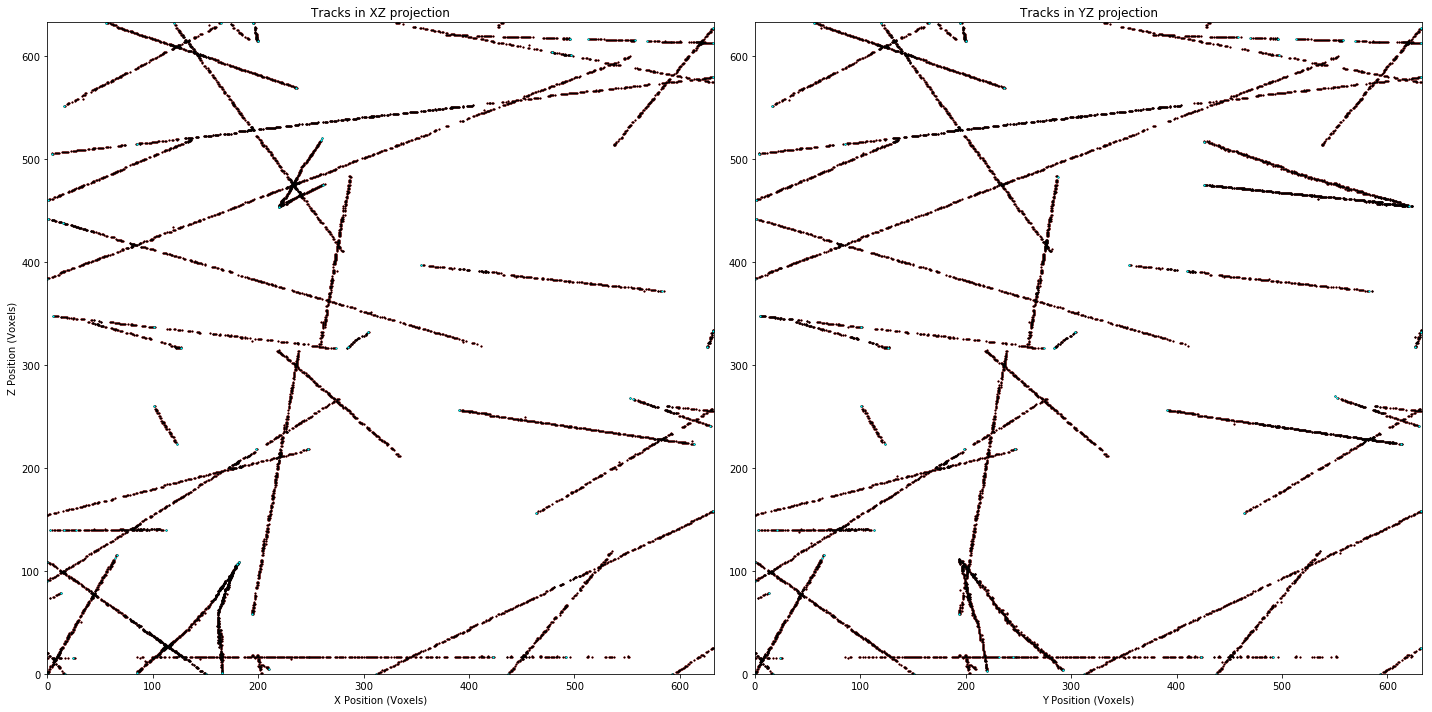

In [19]:
figure_tracks, (ax_tracks_XZ, ax_tracks_YZ) = plt.subplots(1, 2, figsize=(20, 10))

# Plot detector hits
ax_tracks_XZ.plot(hits_XZ[:,0], hits_XZ[:,1], '.', ms=2, color='red') 
ax_tracks_YZ.plot(hits_YZ[:,0], hits_YZ[:,1], '.', ms=2, color='red')

# Plot tracks
for i in range(len(tracks_XZ)):
    ax_tracks_XZ.plot(tracks_XZ[i][:,0], tracks_XZ[i][:,1], '.', ms=2, color='black')
for i in range(len(tracks_YZ)):
    ax_tracks_YZ.plot(tracks_YZ[i][:,0], tracks_YZ[i][:,1], '.', ms=2, color='black')

# Plot terminating points
ax_tracks_XZ.plot(terminate_XZ[:,0], terminate_XZ[:,1], '.', ms=2, color='cyan')
ax_tracks_YZ.plot(terminate_YZ[:,0], terminate_YZ[:,1], '.', ms=2, color='cyan')

# Set axis limits
ax_tracks_XZ.set_xlim(0, columns_XZ)
ax_tracks_XZ.set_ylim(0, rows_XZ)
ax_tracks_YZ.set_xlim(0, columns_YZ)
ax_tracks_YZ.set_ylim(0, rows_YZ)

# Set labels
ax_tracks_XZ.set_xlabel('X Position (Voxels)')
ax_tracks_YZ.set_xlabel('Y Position (Voxels)')
ax_tracks_XZ.set_ylabel('Z Position (Voxels)')

# Set titles
ax_tracks_XZ.set_title('Tracks in XZ projection')
ax_tracks_YZ.set_title('Tracks in YZ projection')

plt.tight_layout() # Spaces titles out properly

# Save figure 
file_tracks_XZYZ ='Output/Tracks_XZYZ.pdf'
plt.savefig(file_tracks_XZYZ)
print('Saving image of tracks to: ' + file_tracks_XZYZ)

plt.show(figure_tracks)

# Find Gamma Rays Amongst Full Tracks

Having full length tracks, we now attempt to find tracks created through electron-positron pair production induced by gamma rays in the volume. The characteristics of these events are that one end of either particle's track will touch or be in very close proximity to the other, and that the two tracks diverge to a sufficient distance after a period of time.

The following code compares each of the full length tracks' endpoints against each other, as well as their distances, in order to determine if a candidate gamma ray is found in either XZ or YZ projections. Following this, we comare the XZ and YZ canddiates to find matches, and collect those full length tracks as pairs in the final gamma ray list.

In [20]:
# Finds gamma ray candidates in given projection
# tracks_proj: Full length tracks in one projection
# proj_type:   Name of projection; Used for logging
def findGammaCandidates(tracks_proj, proj_type):
    candidates = []
    indices = []
    vertices = []

    # Search XZ projection for tracks that touch
    for i in range(len(tracks_proj)):
        for j in range(len(tracks_proj)):
            if(i != j and i not in indices and j not in indices):
                candidate_A = False # Candidate flag for first endpoint possibility
                candidate_B = False # Candidate flag for second endpoint possibility
                
                # Find distances between all endpoint pairs between two tracks
                dist0 = sqrt((tracks_proj[i][0][0] - tracks_proj[j][0][0])**2 + 
                             (tracks_proj[i][0][1] - tracks_proj[j][0][1])**2)
                dist1 = sqrt((tracks_proj[i][0][0] - tracks_proj[j][-1][0])**2 + 
                             (tracks_proj[i][0][1] - tracks_proj[j][-1][1])**2)
                dist2 = sqrt((tracks_proj[i][-1][0] - tracks_proj[j][0][0])**2 + 
                             (tracks_proj[i][-1][1] - tracks_proj[j][0][1])**2)
                dist3 = sqrt((tracks_proj[i][-1][0] - tracks_proj[j][-1][0])**2 + 
                             (tracks_proj[i][-1][1] - tracks_proj[j][-1][1])**2)

                # Find distances between endpoints of individual tracks
                dist_i = sqrt((tracks_proj[i][0][0] - tracks_proj[i][-1][0])**2 + 
                              (tracks_proj[i][0][1] - tracks_proj[i][-1][1])**2)
                dist_j = sqrt((tracks_proj[j][0][0] - tracks_proj[j][-1][0])**2 + 
                              (tracks_proj[j][0][1] - tracks_proj[j][-1][1])**2)

                # Guard to check if track lengths are similar enough to be consistent with gamma ray behaviour
                if(abs(dist_i - dist_j) < 40):
                    if(dist0 < 1 and dist3 > 40):
                        candidate_A = True
                    elif(dist1 < 1 and dist2 > 40):
                        candidate_A = True
                    elif(dist2 < 1 and dist1 > 40):
                        candidate_B = True
                    elif(dist3 < 1 and dist0 > 40):
                        candidate_B = True
                        
                    # Add candidate to list if found
                    if(candidate_A == True):
                        candidates.append(tracks_proj[i])
                        candidates.append(tracks_proj[j])
                        indices.append(i)
                        indices.append(j)
                        vertices.append(tracks_proj[i][0])
                    elif(candidate_B == True):
                        candidates.append(tracks_proj[i])
                        candidates.append(tracks_proj[j])
                        indices.append(i)
                        indices.append(j)
                        vertices.append(tracks_proj[i][-1])
                        
    # Output some useful information
    print('Gamma ray candidates in', proj_type, 'projection:', round(len(candidates)/2))
                        
    return candidates, vertices # Return candidates and their corresponding vertices

In [21]:
gammas_XZ = [] # List of gamma objects in XZ projection
gammas_YZ = [] # List of gamma objects in YZ projection

candidates_XZ, vertices_XZ = findGammaCandidates(tracks_XZ, 'XZ')
candidates_YZ, vertices_YZ = findGammaCandidates(tracks_YZ, 'YZ')

# Search XZ and YZ candidates for matching gamma structures
for i in range(len(vertices_XZ)):
    for j in range(len(vertices_YZ)):
        if(abs(vertices_XZ[i][1] - vertices_YZ[j][1]) < 30):
            gammas_XZ.append([candidates_XZ[2*i], candidates_XZ[2*i+1]])
            gammas_YZ.append([candidates_YZ[2*j], candidates_YZ[2*j+1]])
            
# Output some useful information
print('\nReconstructed gamma rays:', len(gammas_XZ))

Gamma ray candidates in XZ projection: 2
Gamma ray candidates in YZ projection: 2

Reconstructed gamma rays: 2


# Plot Reconstructed Gamma Rays

Saving image of gamma ray tracks to: Output/Gammas_XZYZ.pdf


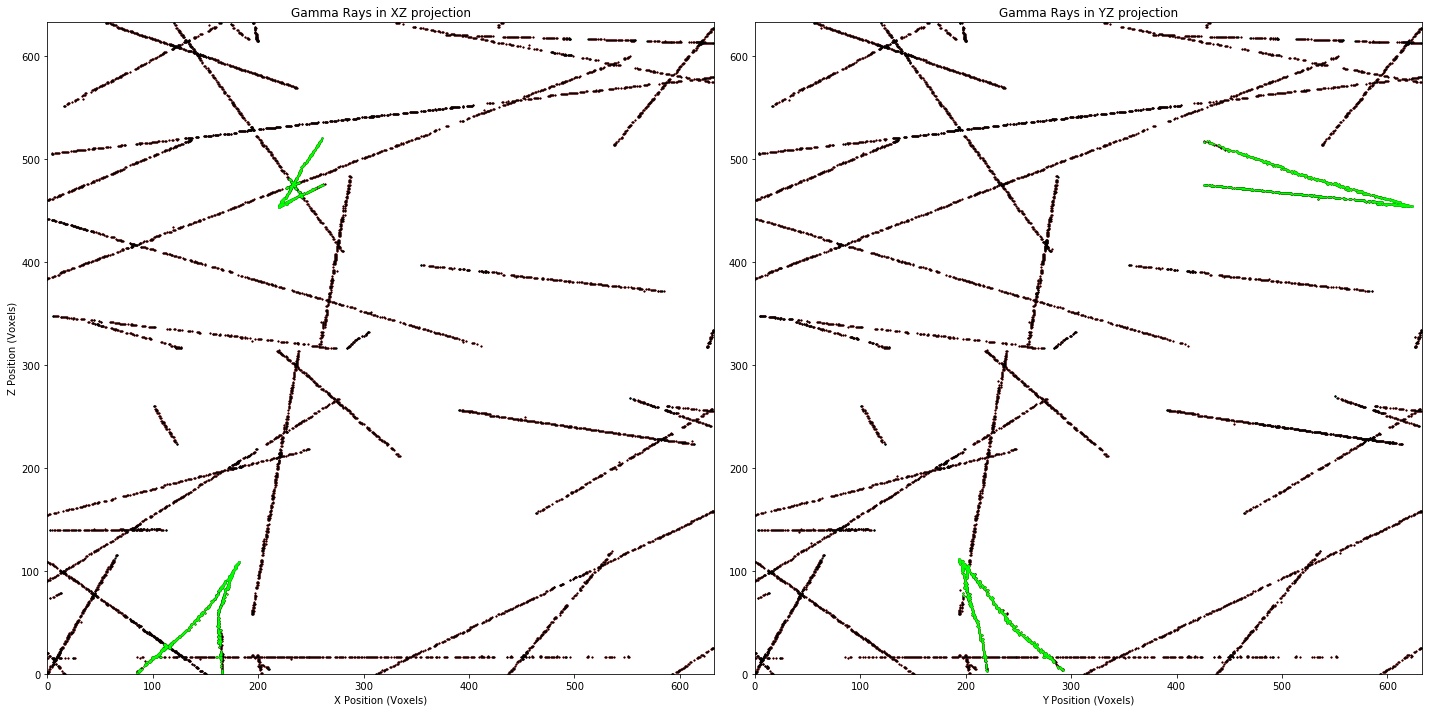

In [22]:
figure_gammas, (ax_gammas_XZ, ax_gammas_YZ) = plt.subplots(1, 2, figsize=(20, 10))

# Plot detector hits
ax_gammas_XZ.plot(hits_XZ[:,0], hits_XZ[:,1], '.', ms=2, color='red') 
ax_gammas_YZ.plot(hits_YZ[:,0], hits_YZ[:,1], '.', ms=2, color='red')

# Plot terminating points
ax_gammas_XZ.plot(terminate_XZ[:,0], terminate_XZ[:,1], '.', ms=2, color='cyan') 
ax_gammas_YZ.plot(terminate_YZ[:,0], terminate_YZ[:,1], '.', ms=2, color='cyan')

# Plot tracks
for i in range(len(tracks_XZ)):
    ax_gammas_XZ.plot(tracks_XZ[i][:,0], tracks_XZ[i][:,1], '.', ms=2, color='black')
for i in range(len(tracks_YZ)):
    ax_gammas_YZ.plot(tracks_YZ[i][:,0], tracks_YZ[i][:,1], '.', ms=2, color='black')

# Plot gamma ray tracks
for i in range(len(gammas_XZ)):
    ax_gammas_XZ.plot(gammas_XZ[i][0][:,0], gammas_XZ[i][0][:,1], '.', ms=2, color='lime')
    ax_gammas_XZ.plot(gammas_XZ[i][1][:,0], gammas_XZ[i][1][:,1], '.', ms=2, color='lime')
for i in range(len(gammas_YZ)):
    ax_gammas_YZ.plot(gammas_YZ[i][0][:,0], gammas_YZ[i][0][:,1], '.', ms=2, color='lime')
    ax_gammas_YZ.plot(gammas_YZ[i][1][:,0], gammas_YZ[i][1][:,1], '.', ms=2, color='lime')      
    
# Set axis limits
ax_gammas_XZ.set_xlim(0, columns_XZ)
ax_gammas_XZ.set_ylim(0, rows_XZ)
ax_gammas_YZ.set_xlim(0, columns_YZ)
ax_gammas_YZ.set_ylim(0, rows_YZ)

# Set labels
ax_gammas_XZ.set_xlabel('X Position (Voxels)')
ax_gammas_YZ.set_xlabel('Y Position (Voxels)')
ax_gammas_XZ.set_ylabel('Z Position (Voxels)')

# Set titles
ax_gammas_XZ.set_title('Gamma Rays in XZ projection')
ax_gammas_YZ.set_title('Gamma Rays in YZ projection')

plt.tight_layout() # Spaces titles out properly

# Save figure 
file_gammas_XZYZ ='Output/Gammas_XZYZ.pdf'
plt.savefig(file_gammas_XZYZ)
print('Saving image of gamma ray tracks to: ' + file_gammas_XZYZ)

plt.show(figure_gammas)

# Categorization of Gamma Ray Events

Categroize gamma ray event energy by analysis of ionization distribution along the length of the track

In [23]:
# NOTE: Categorization of gamma ray events not implemented